# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 30.01.2025

Мягкий дедлайн: 23:59MSK 16.02.2025

Жесткий дедлайн: 23:59MSK 23.02.2025

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Использование генеративных языковых моделей разрешено только в случае явного указания на это. Необходимо прописать (в соответствующих пунктах, где использовались, либо в начале/конце работы):
- какая языковая модель использовалась
- какие использовались промпты и в каких частях работы
- с какими сложностями вы столкнулись при использовании генеративных моделей, с чем они помогли больше всего

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

In [2]:
%load_ext autoreload
%autoreload 2

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [12]:
import numpy as np

# 1 Способ 
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()

# 2 Способ (если первый не работает)
# from sklearn.datasets import fetch_openml
# def load_fashion_mnist():
#     X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
#     X = X.reshape(-1, 28, 28).astype('uint8')
#     y = y.astype('int64')
#     x_train, x_test = X[:60000], X[60000:]
#     y_train, y_test = y[:60000], y[60000:]
#     return (x_train, y_train), (x_test, y_test)
# (x_train_pics, y_train), (x_test_pics, y_test) = load_fashion_mnist()




x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

__Задание 0. (0.25 баллов)__

**Вопрос:** зачем в алгоритме нужен метод главных компонент? 

**Ответ:** Для rff нужно большое количество скалярных произведений. А наши данные имеют размерность 784. Следовательно для оптимизации работы нам нужно снизить размерность, что и делает МГК. Также он позволяет убрать избыточные признаки, что позволяет улучшить приближение ядра.

__Задание 1. (3 балла)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса в `homework_practice_08_rff.py` (допишите его и исправьте несостыковки в классе пайплайна) или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [4]:
%%time
from homework_practice_08_rff import RFFPipeline, RandomFeatureCreator
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

pipeline = RFFPipeline(n_features=1000, new_dim=50, classifier_class=LogisticRegression, feature_creator_class=RandomFeatureCreator)
pipeline.fit(x_train,y_train)
y_pred = pipeline.predict(x_test)
print("logreg accuracy:", accuracy_score(y_pred, y_test))

/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logreg accuracy: 0.8721
CPU times: user 1min 31s, sys: 5.47 s, total: 1min 36s
Wall time: 1min 3s


In [29]:
%%time
from sklearn.svm import SVC
pipeline_svm = RFFPipeline(n_features=1000, new_dim=50, classifier_class=SVC, feature_creator_class=RandomFeatureCreator)
pipeline_svm.fit(x_train, y_train)
y_pred = pipeline_svm.predict(x_test)
print("svm accuracy:", accuracy_score(y_pred, y_test))

svm accuracy: 0.8783
CPU times: user 9min 7s, sys: 5.07 s, total: 9min 13s
Wall time: 9min 17s


__Задание 2. (2.5 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучите градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost. 

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [14]:
%%time
# Linear_SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
svm_classifier = LinearSVC(max_iter=10000, dual = 'auto')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

KeyboardInterrupt: 

Я случайно запустил клетку перед отправкой дз, а она долго исполняется(. Но результат до этого был че-то типо 0.83

In [32]:
%%time
# Kernel_SVC
svm_classifier = SVC(max_iter=10000, kernel = 'rbf')
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_test)
print('Accuracy:', accuracy_score(y_pred, y_test))

Accuracy: 0.8828
CPU times: user 6min 58s, sys: 2.09 s, total: 7min
Wall time: 7min 2s


Линейный svm работает сильно дольше, а качество при этом хуже

In [9]:
# Boosting
import xgboost as xgb
import optuna
from sklearn.decomposition import PCA

pca = PCA(50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.fit_transform(x_test)
def opt(trial):
    params = {
        'subsample' : trial.suggest_float('subsample', 0.001, 1),
        'learning_rate' : trial.suggest_float('eta', 0.001, 1),
        'gamma' : trial.suggest_float('gamma', 0, 10),
        'max_depth' : trial.suggest_int('max_depth', 1, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 1, 200)}
    model = xgb.XGBClassifier(params, objective='multi:softprob')

    model.fit(x_train_pca, y_train)
    return accuracy_score(y_test, model.predict(x_test_pca))


boosting = optuna.create_study(direction='maximize')
boosting.optimize(opt, n_trials=10)

score = boosting.best_value
print("accuracy:", boosting.best_value)

[I 2025-02-23 19:30:25,935] A new study created in memory with name: no-name-cf18a26e-c262-4655-9252-3895a31b2324
/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
[I 2025-02-23 19:35:17,602] Trial 0 finished with value: 0.5451 and parameters: {'subsample': 0.9331616935017512, 'eta': 0.20202822846920207, 'gamma': 1.2478144188721652, 'max_depth': 8, 'n_estimators': 115}. Best is trial 0 with value: 0.5451.
/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
[I 2025-02-23 19:40:20,386] Trial 1 finished with value: 0.5451 and parameters: {'subsample': 0.5702419274576634, 'eta': 0.015693763832350008, 'gamma': 5.747435292147356, 'max_depth': 3, 'n_estimators': 32}. Best is trial 0 with value: 0.5451.
/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/xgboost/cor

accuracy: 0.5451


Бустинг работал долго и дал результаты значительно хуже

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [15]:
#1
no_pca = RFFPipeline(classifier_class=LogisticRegression, use_PCA=False)
no_pca.fit(x_train, y_train)
y_pred = no_pca.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))

accuracy: 0.1003


без PCA качество как у рандома

 12%|█████▋                                       | 1/8 [00:05<00:36,  5.26s/it]/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|███████████▎                                 | 2/8 [00:11<00:35,  5.94s/it]/Users/ilushka/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

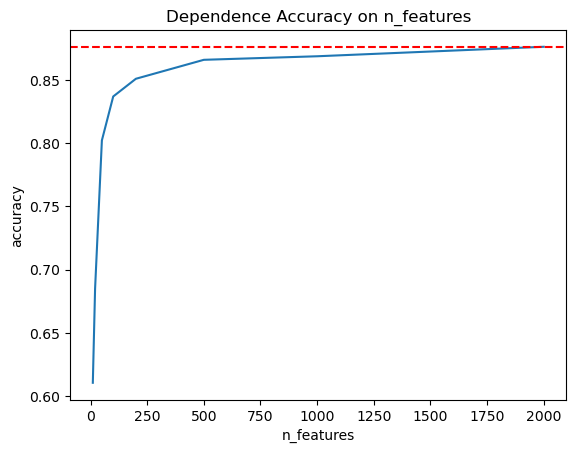

In [6]:
#2
import matplotlib.pyplot as plt
from tqdm import tqdm

n_features_list = [10, 20, 50, 100, 200, 500, 1000, 2000]
scores = []
for n_features in tqdm(n_features_list):
    pipeline = RFFPipeline(classifier_class=LogisticRegression, use_PCA=True, n_features=n_features)
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(n_features_list, scores)
plt.axhline(scores[-1], color = 'red', linestyle = '--')
plt.title('Dependence Accuracy on n_features')
plt.xlabel('n_features')
plt.ylabel('accuracy')
plt.show()

как мы видим в увеличении количества признаков с приблизительно n_features=1000 нет смысла

In [ ]:
#3 (проводил выше в задании 1 для проверки кода)

у SVM accuracy оказалался немного выше, но не значительно. Поэтому не так важно какую модель обучать

__Задание 4. (Максимум 1.5 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет), n_features=new_dim и n_features < new_dim также должны работать, убедитесь в этом. Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы. 


__Задание 5. (Максимум 1 балл)__

Существует большое количество работ, где идея RFF развивается, предлагаются её обобщения (которые, по сути, выливаются в другие преобразования признаков, не обязательно уже тригонометрические). Возьмите любую из таких работ, кратко опишите идею, имплементируйте её и сравните качество с ORF и RFF, которые вы запрограммировали выше.

Ссылки на статьи, где обсуждаются вариации RFF для разных ядер, можно найти в окрестности таблицы 1 в работе https://arxiv.org/pdf/1407.5599  

___ссылка на работу:___

___описание идеи:___

In [ ]:
# Пример 

__Задание 6. (Максимум 2.5 балла)__

Реализуйте класс ядровой Ridge регрессии (Лекция 13, $\S 1.2$), для оптимизации используте градиентный спуск **[1 балл максимум]**, также добавьте возможность использовать аналитическую формулу **[1 балл максимум]**. Для градиентного спуска выпишите градиент ниже **[0.5 баллов максимум]**. 
Подумайте о том, как в формулах правильно учесть свободный коэффициент. 

Затем адаптируйте вашу реализацию RFF под задачу регрессии. Сравните вашу ядровую регрессию и RFF на синтетических данных.

Функция потерь: 
$$
Q(w) = \frac{1}{2} ||\Phi \Phi^T w - y||^2 + \frac{\lambda}{2} w^T \Phi \Phi^T w \rightarrow \min_w,
$$
где $\Phi \Phi^T = K$, $K = (k(x_i, x_j))_{i, j = 1}^{\ell}$.

Предсказание: 
$
y(x) = k(x)^T w,
$
где $k(x)$ — вектор функций ядра от пар объектов $(x, x_i)_{i=1}^{\ell}$.

___Выведите градиент:___ 
$$
\nabla ...
$$

Вы можете изменять представленный шаблон в файле `homework_practice_08_kernel_regression.py` по своему усмотрению.

In [ ]:
from homework_practice_08_kernel_regression import KernelRidgeRegression